In [9]:
import numpy as np
import sys
from statsmodels.tsa.arima.model import ARIMA 
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.functional as F
from torch import optim
sys.path.append('../')

from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder
from Andreini_data.data import load_y

## Implementing the MCMC procedure as proposed by Andreini 
We consider the model
$$
\mathbf{\mathbb{f}}_t = G(\mathbf{y}_t) \\ 
\mathbf{y}_t = F(\mathbf{\mathbb{f}}_t) + \mathbf{\varepsilon}_t \\ 
\mathbf{\mathbb{f}}_t = \mathbf{B}_1 \mathbf{f}_{t-1} + \cdots + \mathbf{B}_p \mathbf{f}_{t-p} + \mathbf{u}_t \\
\mathbf{\varepsilon}_t = \mathbf{\Phi_1} \mathbf{\varepsilon}_{t-1} + \cdots \mathbf{\Phi_d} \mathbf{\varepsilon}_{t-d} + \mathbf{\epsilon}_t 
$$


In [67]:
class ArProcess():
    """
    class containing the autoregressive processes of the idiosyncratic error terms \varepsilon_t
    This should be a var process if Q can be nondiagonal
    """
    def __init__(self, T:int, n:int, d:int):
        self.n = n
        self.T = T 
        self.d = d #number of lags
        self.models = None
        self.parameters = None

    def fit(self, x):
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[:,i]) for i in range(x.shape[1])]
        self.fitted = [mod.fit() for mod in self.models]
        return self

    def conditionalExpectation(self):
        """
        obtain Phi(L)eps_t
        """
        return np.stack([mod.predict() for mod in self.fitted]).T
    
    def simulate(self):
        return np.stack([mod.simulate(nsimulations=self.T) for mod in self.fitted]).T

In [65]:
ar.fitted[0].simulate(nsimulations=100)

array([ 5.61750729e-01, -4.83481073e-01, -1.12456278e+00, -5.81501018e-01,
       -5.12214249e-01,  4.22312660e-01, -7.05917343e-01,  9.60913253e-01,
        1.83351885e+00,  6.12602329e-01, -1.28654914e+00,  5.36106872e-01,
       -1.44111582e+00, -5.86677635e-01,  1.95245561e+00, -1.26475839e+00,
        4.64503726e-01,  3.93904451e-03,  7.55843659e-01,  7.67771863e-01,
       -3.98838010e-01, -2.08972118e+00, -7.84002315e-01, -1.45517168e-01,
        1.16172805e+00,  7.93789324e-01,  1.30374897e+00, -1.24531395e+00,
       -8.55454260e-01, -7.22220252e-03,  7.96873871e-01,  1.59105710e-01,
        1.10839789e+00, -7.54921401e-01, -1.80847541e+00, -2.29622361e-01,
        8.73344514e-01,  1.40336688e+00, -1.52494402e-02,  1.89013202e-01,
       -6.42823407e-01, -6.02337686e-01, -6.74030334e-01, -1.65972906e-03,
       -6.41697574e-01, -1.82249634e+00, -2.46398696e-01, -1.37358147e+00,
       -6.52461963e-01,  2.09156462e+00, -1.12725199e+00, -1.37323012e-01,
       -2.98233601e-01,  

In [68]:
n = 10
T = 100
eps = np.random.normal(size = (T,n))
print(eps.shape)
ar = ArProcess(T,n,1)
ar.fit(eps)
pred = ar.conditionalExpectation()
print(pred.shape)
sim = ar.simulate()
sim.shape

(100, 10)
(100, 10)


(100, 10)

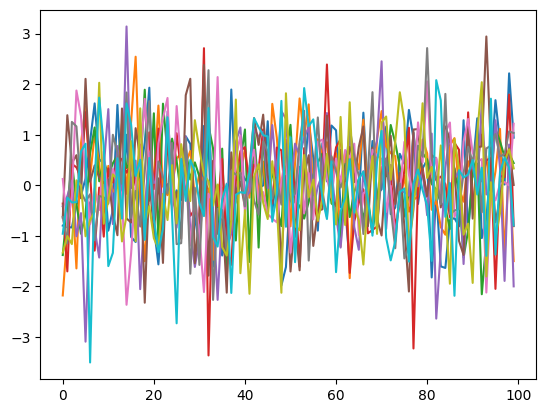

In [20]:
#plt.plot(eps.T);
plt.plot(sim);

In [81]:
def init_eps(T,n):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    return np.random.normal(size = (T,n))

def d2FMMCMC(y: np.ndarray, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module):
    n = y.shape[1]
    T = y.shape[0]
    eps = init_eps(T,n)
    print(eps.shape)
    phi = ArProcess(T,n,d=1).fit(eps)
    convergence = False
    loss_hist = []
    y_tensor = torch.from_numpy(y).float()
    i = 0
    while not convergence:
        print(i)
        print(y.shape, phi.conditionalExpectation().shape )
        y_tilde = y - phi.conditionalExpectation()
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde+phi.simulate()

            optimizer.zero_grad()
            model_in = torch.from_numpy(y_tilde_mc).float()
            out = model(model_in)
            loss  = criterion(out, model_in)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
        eps = y - model(y_tensor).detach().numpy()
        phi = ArProcess(T,n,d=1).fit(eps)
        i+=1
        convergence = i = 5
    return phi, model, loss_hist

## Test

In [82]:
y = load_y()
input_dim = y.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, factor_dim], activation=nn.Identity()) #fully linear
dec = Decoder(hidden_dim = [factor_dim, input_dim])
model = AutoEncoder(enc, dec)
phi, model, loss_hist = d2FMMCMC(y=y, model=model, n_epoch=10, optimizer = optim.Adam(params=model.parameters(),lr=0.01), criterion= nn.MSELoss())

(529, 103)
0
(529, 103) (529, 103)


/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarn

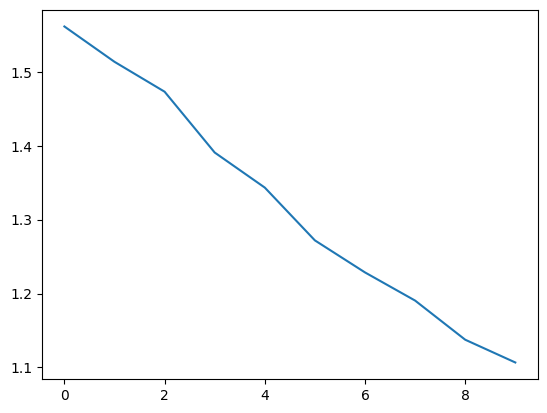

In [83]:
plt.plot(loss_hist)